In [1]:
## importing the necessary libraries

import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utility import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0) 


### Model Architecture

In [2]:
class FouirerLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(FouirerLayer, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width, strain_channels):
        super(FNO2d, self).__init__()


        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.strain_channels  = strain_channels
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) ##input channels := [x y Material]

        self.conv0 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        #self.fc2 = nn.Linear(2097152, 100)
        #self.fc3=  nn.Linear(100,1)## output channels := [xx,yy,xy]



        ### layers for reducing the size of the model; additionally being added now
        self.fct1=nn.Conv2d(128,50,3,1)
        self.fct2=nn.Conv2d(50,10,3,2)
        self.fct3=nn.Conv2d(10,1,3,2)
        self.last_linear=nn.Linear(900,1)

        ####### done with the additon of layers

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)  
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        #############################
        #n_out=nin+2p-k/stride
        ## increase the number of strides or increase the kernel size
        ## instead of flattening try to do using convolutional layers

        x=x.permute(0,3,1,2)
        x=self.fct1(x)
        x=self.fct2(x)
        x=self.fct3(x)
        x=x.permute(0,2,3,1)
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        
        x=self.last_linear(x)


        ##########
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [3]:
class FouirerLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(FouirerLayer, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width, strain_channels):
        super(FNO2d, self).__init__()


        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.strain_channels  = strain_channels
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) ##input channels := [x y Material]

        self.conv0 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = FouirerLayer(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        #self.fc2 = nn.Linear(2097152, 100)
        #self.fc3=  nn.Linear(100,1)## output channels := [xx,yy,xy]



        ### layers for reducing the size of the model; additionally being added now
        self.fct1=nn.Conv2d(128,50,3,1)
        self.fct2=nn.Conv2d(50,10,3,2)
        self.fct3=nn.Conv2d(10,1,3,2)
        self.last_linear=nn.Linear(900,1)

        ####### done with the additon of layers

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)  
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        #############################
        #n_out=nin+2p-k/stride
        ## increase the number of strides or increase the kernel size
        ## instead of flattening try to do using convolutional layers

        x=x.permute(0,3,1,2)
        x=self.fct1(x)
        x=self.fct2(x)
        x=self.fct3(x)
        x=x.permute(0,2,3,1)
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        
        x=self.last_linear(x)


        ##########
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

import torch
t = torch.empty(2,2,3,3).random_(30)
#print("Tensor:", t)
print("Size of Tensor:", t.size())

# flatten the above tensor using end_dims
flatten_t0 = torch.flatten(t, start_dim=1, end_dim=-1)

# print the flatten tensors
print("Flatten tensor (start_dim=1,end_dim=3):", flatten_t0)
print(flatten_t0.size())

The maximum value of labels are [9.97127572e-07]
The mean and standard deviation of permeability are 1.6356765497445424e-06,3.895870047510142e-07


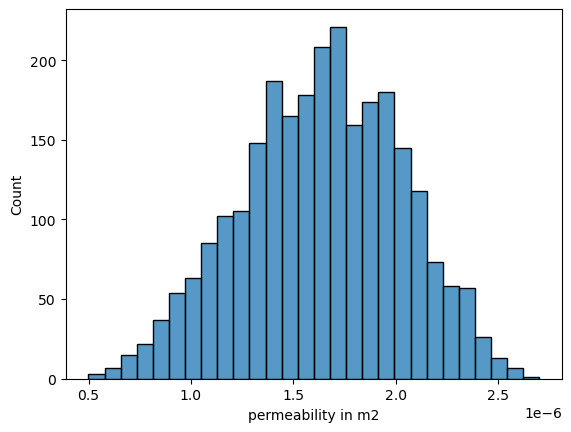

In [4]:
import re
import seaborn as sns
import pickle
with open('dataset_file.pkl','rb') as file_handle:
    permu_dict=pickle.load(file_handle)

images=list(permu_dict.values())
labels=list(permu_dict.keys())
print('The maximum value of labels are', max(labels))
labels=[float(re.sub(r"[\[\]]",'',elem)) for elem in labels]
sns.histplot(labels)
plt.xlabel('permeability in m2')
print('The mean and standard deviation of permeability are {},{}'.format(np.mean(labels),np.std(labels)))
labels=[np.log(elem) for elem in labels]

images=np.array(images)
#images_tens=torch.Tensor(images)

#labels=torch.Tensor(np.array(labels))

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(images,labels,test_size=.3,random_state=42,shuffle=True)
x_train,x_test,y_train,y_test=torch.Tensor(x_train),torch.Tensor(x_test),torch.Tensor(y_train),torch.Tensor(y_test)
x_train=x_train[:1200,:,:]
x_test=x_test[:300,:,:]
y_train=y_train[:1200]
y_test=y_test[:300]
test_geo=x_test


#print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
ntrain = 1200
ntest = 300
example=x_train[0]

In [5]:
print(x_train.shape)

torch.Size([1200, 128, 128])


In [6]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

dim = 128 # image resolution

x_train = x_train.reshape(ntrain,dim,dim,1)
x_test = x_test.reshape(ntest,dim,dim,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([1200, 128, 128, 1]) torch.Size([1200]) torch.Size([300, 128, 128, 1]) torch.Size([300])


In [6]:
max(y_train)

tensor(1.8439)

Text(0.5, 1.0, 'Distribution in log form')

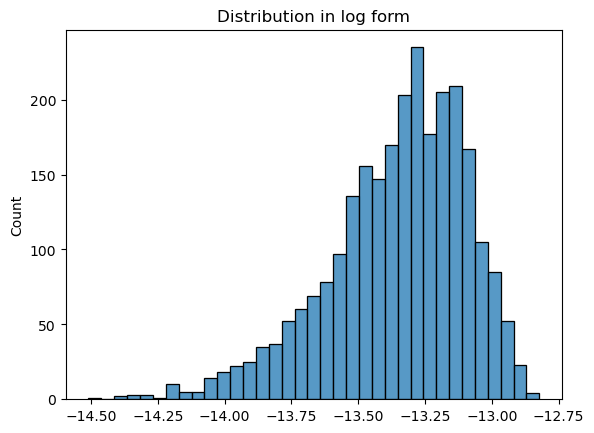

In [7]:
sns.histplot(labels)
plt.title('Distribution in log form')

Text(0.5, 1.0, 'Training example visualization after standardizing')

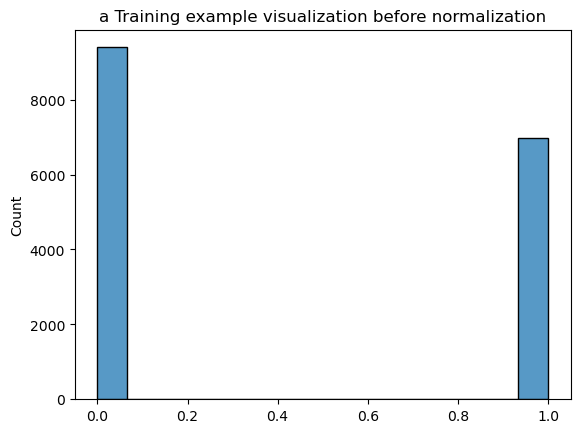

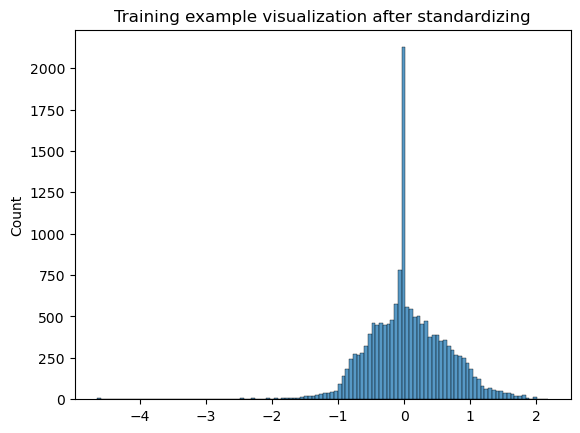

In [8]:
import seaborn as sns
sns.histplot(example.reshape(-1))
plt.title('a Training example visualization before normalization')
plt.figure()
sns.histplot(x_train[1].reshape(-1))
plt.title('Training example visualization after standardizing')

### Reading the Data:

In [9]:
x_test.shape

torch.Size([300, 128, 128, 1])

In [8]:
## hyp par settings

batch_size = 20
learning_rate = 0.01
step_size = 100
epochs = 50
gamma = 0.5
modes =12
width = 32

In [11]:
x_train[0].unique()

tensor([-3.7399, -3.5103, -3.4688,  ...,  2.2692,  2.2974,  2.3046])

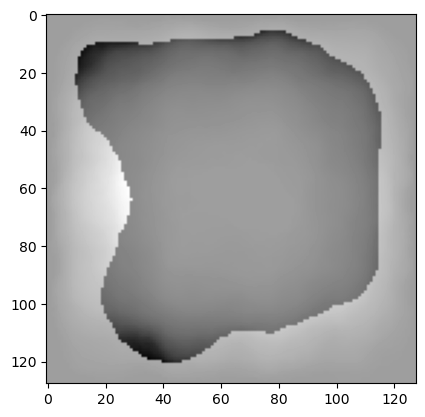

In [12]:
plt.imshow(x_train[0].reshape(128,128),cmap='gray')

tensor(2.1829)


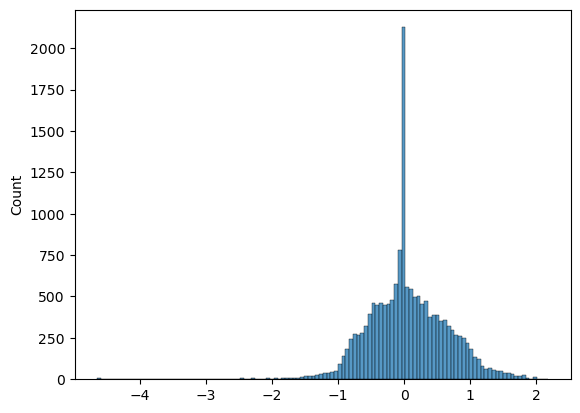

In [12]:
sns.histplot(x_train[1].reshape(-1))
print(max(x_train[1].reshape(-1)))

#plt.imshow(x_test[:21].reshape(128,128))
array_ans=model(x_test[:21].cuda())
ans_test=y_test[:21]
for index,image in enumerate(x_test[:21]):
    print(index)
    plt.figure()
    plt.imshow(image.reshape(128,128),cmap='gray')
    print(array_ans[index],ans_test[index])
    


In [9]:
strain_channels = 1
model = FNO2d(modes, modes, width, strain_channels).cuda()
print(f'MODEL PARAMETERS. :== {count_params(model)}')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)


MODEL PARAMETERS. :== 1251376


In [14]:
torch.cuda.is_available()

True

### Training--STRAIN MODEL

In [15]:

myloss = L2Loss(size_average=False)
y_normalizer.cuda()

## ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        #print('The shape of x and y is {} and {}'.format(x.shape,y.shape))
        
        optimizer.zero_grad()

        out = model(x).reshape(batch_size,1)
        
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(batch_size,1)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 6.7879 || TrainError:== 0.063436  ||  TestError:== 0.152647
 Epoch :== 2  ||  TIME(sec):== 4.1261 || TrainError:== 0.0073  ||  TestError:== 0.113089
 Epoch :== 3  ||  TIME(sec):== 4.1402 || TrainError:== 0.004784  ||  TestError:== 0.130617
 Epoch :== 4  ||  TIME(sec):== 4.1474 || TrainError:== 0.004494  ||  TestError:== 0.06981
 Epoch :== 5  ||  TIME(sec):== 4.1456 || TrainError:== 0.004559  ||  TestError:== 0.050123
 Epoch :== 6  ||  TIME(sec):== 4.144 || TrainError:== 0.004135  ||  TestError:== 0.050695
 Epoch :== 7  ||  TIME(sec):== 4.1482 || TrainError:== 0.003995  ||  TestError:== 0.057656
 Epoch :== 8  ||  TIME(sec):== 4.1535 || TrainError:== 0.003082  ||  TestError:== 0.077136
 Epoch :== 9  ||  TIME(sec):== 4.1591 || TrainError:== 0.002924  ||  TestError:== 0.095907
 Epoch :== 10  ||  TIME(sec):== 4.1718 || TrainError:== 0.004242  ||  TestError:== 0.110076
 Epoch :== 11  ||  TIME(sec):== 4.1686 || TrainError:== 0.002536  ||  TestError:== 0.052637
 

In [37]:
checkpoint={'state_dictG':model.state_dict(),'optimizer':optimizer.state_dict()}
torch.save(checkpoint,'darcy_model_permu_reduced_size.pth')

In [10]:
## loading the checkpoint
checkpoint=torch.load('darcy_model_permu_reduced_size.pth')
model.load_state_dict(checkpoint['state_dictG'])
optimizer.load_state_dict(checkpoint['optimizer'])
##model.eval() uncomment it if you are using for training again

In [15]:
## how can i check the whether gradients flow through fno and come back to the input
input_image=torch.randn(1,128,128,1)
input_image.requires_grad_()
input_image_seq1=input_image*1
output=model(input_image_seq1.to(device))
output.sum().backward()
print(input_image.grad)
print(input_image.grad.shape)

tensor([[[[-3.5993e-04],
          [ 3.5844e-05],
          [ 9.8186e-05],
          ...,
          [-6.0126e-04],
          [ 1.1445e-04],
          [-3.6545e-05]],

         [[-2.6168e-05],
          [-6.0915e-05],
          [ 1.8156e-04],
          ...,
          [ 1.2076e-04],
          [ 1.4219e-04],
          [ 1.2574e-04]],

         [[ 3.3293e-05],
          [ 1.1493e-04],
          [ 1.2714e-04],
          ...,
          [-5.7773e-05],
          [ 1.1374e-04],
          [ 1.1676e-04]],

         ...,

         [[-3.0058e-05],
          [-4.7327e-05],
          [-7.1998e-05],
          ...,
          [ 8.9460e-06],
          [ 1.2831e-07],
          [-2.4614e-05]],

         [[-2.3859e-05],
          [-1.2199e-04],
          [-3.8712e-05],
          ...,
          [ 8.7741e-06],
          [ 2.0098e-05],
          [ 1.4521e-05]],

         [[ 5.7495e-05],
          [ 7.0806e-07],
          [-9.4355e-06],
          ...,
          [ 5.0231e-05],
          [ 1.0998e-04],
          

In [17]:
## how can i check the whether gradients flow through fno and come back to the input
input_image=torch.randn(1,128,128,1)
input_image=x_normalizer.encode(input_image)
input_image.requires_grad_()
input_image_seq1=input_image*1
output=model(input_image_seq1.to(device))
print('the output is ',output)
output_denorm=y_normalizer.decode(output)
final=torch.exp(output_denorm)
print('the final is ',final)
output.sum().backward()
print(input_image.grad)
print(input_image.grad.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16384x130 and 3x32)

In [56]:
print(input_image.grad)
print(input_image.requires_grad)

None
True


In [90]:
x=torch.tensor(10.,requires_grad=True)
y=(x**2)
y=y.requires_grad_()
z=(y**2)
z=z.requires_grad_()
z.sum().backward()



In [36]:
import torch
x=torch.tensor(2.,requires_grad=True)
y=torch.tensor(2+x,requires_grad=True)
#y=x*x
z=y*y
z.sum().backward()
#y.backward(torch.tensor([1.0,1.0,1.0])
print(x.grad)
print(y.grad)


None
tensor(8.)


/tmp/ipykernel_412382/1063705568.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(2+x,requires_grad=True)


In [2]:
x=torch.randn(3,requires_grad=True)
print(x)
y=x+2
print(y)
z=y*y*2
print(z)
z.sum().backward()
print(x.grad)

tensor([1.3465, 0.8931, 1.1130], requires_grad=True)
tensor([3.3465, 2.8931, 3.1130], grad_fn=<AddBackward0>)
tensor([22.3975, 16.7405, 19.3817], grad_fn=<MulBackward0>)
tensor([13.3858, 11.5725, 12.4520])


In [31]:
x=torch.randn(3,requires_grad=True)


print(x)
y=x+2

y.requires_grad_()

z=y
z.sum().backward()
print(x.grad,y.grad)
x.grad.zero_()
#y.grad.zero_()

tensor([ 0.1675, -0.5920, -0.4353], requires_grad=True)
tensor([1., 1., 1.]) None


tensor([0., 0., 0.])

In [25]:
print(x,y,z)

tensor([0.6655, 1.2415, 1.9775], requires_grad=True) tensor([2.6655, 3.2415, 3.9775], grad_fn=<AddBackward0>) tensor([2.6655, 3.2415, 3.9775], grad_fn=<AddBackward0>)


In [20]:
print(y.grad)

None


In [41]:
x.requires_grad_()
y=torch.tensor(y,requires_grad=True)
out=model(y.to(device))
out.mean().backward()

None


In [42]:
print(y.grad_fn)

None


In [43]:
print(out.grad_fn)

In [54]:
x=torch.tensor(25.,requires_grad=True)
y=x*2
y.requires_grad_()

tensor(50., grad_fn=<MulBackward0>)

In [56]:
y.backward()

In [57]:
print(x.grad)

tensor(2.)


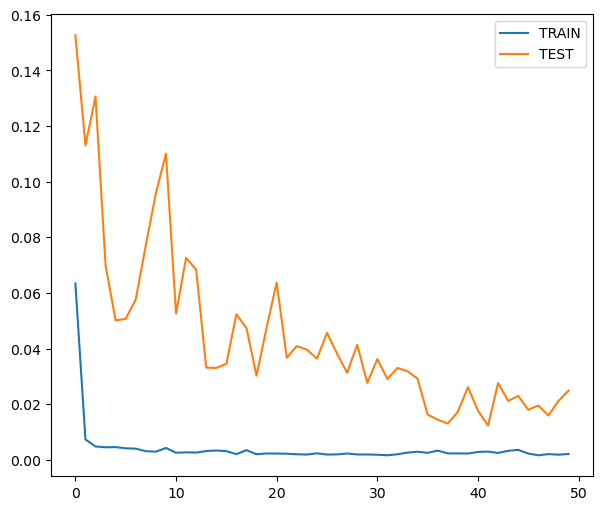

In [16]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [62]:
max(y_test)

tensor(-12.8818)

In [12]:
## testing
stats=[]
for num in range(len(y_test)):
#plt.imshow(x_test[0],cmap='gray')
      print('the labeled target value is {}'.format(np.exp(y_test[num])))
for num in range(len(y_test)//20):
    test=x_test[20*num:20*num+20,:,:,:].to(device)
    stats+=(y_normalizer.decode(model(test)).cpu().detach().numpy()).tolist()
    print('im what you looiking for, here is my value',stats)
    print(np.exp(y_normalizer.decode(model(test)).cpu().detach().numpy()))


the labeled target value is 1.2871306580564124e-06
the labeled target value is 1.7827043166107615e-06
the labeled target value is 1.6050192925831652e-06
the labeled target value is 1.4814105497862329e-06
the labeled target value is 1.5390766066047945e-06
the labeled target value is 1.3343779983188142e-06
the labeled target value is 1.8983665768246283e-06
the labeled target value is 1.774538532117731e-06
the labeled target value is 1.5560357269350789e-06
the labeled target value is 1.5367621699624578e-06
the labeled target value is 1.970396624528803e-06
the labeled target value is 1.8510834252083441e-06
the labeled target value is 9.492399613009184e-07
the labeled target value is 1.5535860029558535e-06
the labeled target value is 1.3340981013243436e-06
the labeled target value is 2.1201960862526903e-06
the labeled target value is 1.652752644076827e-06
the labeled target value is 8.224268412959646e-07
the labeled target value is 1.9782046365435235e-06
the labeled target value is 1.802739

im what you looiking for, here is my value [[-13.590192794799805], [-13.237594604492188], [-13.322821617126465], [-13.429393768310547], [-13.400485038757324], [-13.50173282623291], [-13.147236824035645], [-13.229560852050781], [-13.380046844482422], [-13.383728981018066], [-13.121625900268555], [-13.15643310546875], [-13.896021842956543], [-13.366207122802734], [-13.530176162719727], [-13.035017967224121], [-13.30107593536377], [-14.103049278259277], [-13.12339973449707], [-13.239140510559082], [-13.468913078308105], [-13.077561378479004], [-13.673830032348633], [-13.520306587219238], [-13.60225772857666], [-13.020931243896484], [-13.690503120422363], [-13.211309432983398], [-12.903071403503418], [-12.987868309020996], [-13.26520824432373], [-13.129223823547363], [-13.395208358764648], [-13.05406379699707], [-13.491117477416992], [-12.918042182922363], [-13.082842826843262], [-13.221896171569824], [-13.269298553466797], [-13.1103515625], [-13.354391098022461], [-12.936128616333008], [-

im what you looiking for, here is my value [[-13.590192794799805], [-13.237594604492188], [-13.322821617126465], [-13.429393768310547], [-13.400485038757324], [-13.50173282623291], [-13.147236824035645], [-13.229560852050781], [-13.380046844482422], [-13.383728981018066], [-13.121625900268555], [-13.15643310546875], [-13.896021842956543], [-13.366207122802734], [-13.530176162719727], [-13.035017967224121], [-13.30107593536377], [-14.103049278259277], [-13.12339973449707], [-13.239140510559082], [-13.468913078308105], [-13.077561378479004], [-13.673830032348633], [-13.520306587219238], [-13.60225772857666], [-13.020931243896484], [-13.690503120422363], [-13.211309432983398], [-12.903071403503418], [-12.987868309020996], [-13.26520824432373], [-13.129223823547363], [-13.395208358764648], [-13.05406379699707], [-13.491117477416992], [-12.918042182922363], [-13.082842826843262], [-13.221896171569824], [-13.269298553466797], [-13.1103515625], [-13.354391098022461], [-12.936128616333008], [-

[[2.0648515e-06]
 [2.3380546e-06]
 [2.1374933e-06]
 [1.3206432e-06]
 [2.2360421e-06]
 [1.3405285e-06]
 [1.6004049e-06]
 [4.6579765e+06]
 [1.3970645e-06]
 [1.4195767e-06]
 [1.1017900e-06]
 [2.1328874e-06]
 [1.2918726e-06]
 [1.6868071e-06]
 [1.1523920e-06]
 [1.2561326e-06]
 [1.8126249e-06]
 [1.2505710e-06]
 [1.0407102e-06]
 [2.1386413e-06]]
im what you looiking for, here is my value [[-13.590192794799805], [-13.237594604492188], [-13.322821617126465], [-13.429393768310547], [-13.400485038757324], [-13.50173282623291], [-13.147236824035645], [-13.229560852050781], [-13.380046844482422], [-13.383728981018066], [-13.121625900268555], [-13.15643310546875], [-13.896021842956543], [-13.366207122802734], [-13.530176162719727], [-13.035017967224121], [-13.30107593536377], [-14.103049278259277], [-13.12339973449707], [-13.239140510559082], [-13.468913078308105], [-13.077561378479004], [-13.673830032348633], [-13.520306587219238], [-13.60225772857666], [-13.020931243896484], [-13.690503120422363],

im what you looiking for, here is my value [[-13.590192794799805], [-13.237594604492188], [-13.322821617126465], [-13.429393768310547], [-13.400485038757324], [-13.50173282623291], [-13.147236824035645], [-13.229560852050781], [-13.380046844482422], [-13.383728981018066], [-13.121625900268555], [-13.15643310546875], [-13.896021842956543], [-13.366207122802734], [-13.530176162719727], [-13.035017967224121], [-13.30107593536377], [-14.103049278259277], [-13.12339973449707], [-13.239140510559082], [-13.468913078308105], [-13.077561378479004], [-13.673830032348633], [-13.520306587219238], [-13.60225772857666], [-13.020931243896484], [-13.690503120422363], [-13.211309432983398], [-12.903071403503418], [-12.987868309020996], [-13.26520824432373], [-13.129223823547363], [-13.395208358764648], [-13.05406379699707], [-13.491117477416992], [-12.918042182922363], [-13.082842826843262], [-13.221896171569824], [-13.269298553466797], [-13.1103515625], [-13.354391098022461], [-12.936128616333008], [-

[[1.8506933e-06]
 [1.7842181e-06]
 [2.1420030e-06]
 [1.2967000e-06]
 [1.9894578e-06]
 [1.5631437e-06]
 [2.0991572e-06]
 [1.5036462e-06]
 [1.1801894e-06]
 [1.9388351e-06]
 [1.8223782e-06]
 [2.2394670e-06]
 [1.6420553e-06]
 [1.9178410e-06]
 [1.1795762e-06]
 [1.8427205e-06]
 [1.9995944e-06]
 [1.3780111e-06]
 [2.0124291e-06]
 [1.5792077e-06]]


In [18]:
to_check=np.array(np.exp(y_test))
print(max(to_check))

2.5439465e-06


In [19]:
np.argmax(stats)

187

tensor([[0.1406]], device='cuda:0', grad_fn=<AddmmBackward0>)

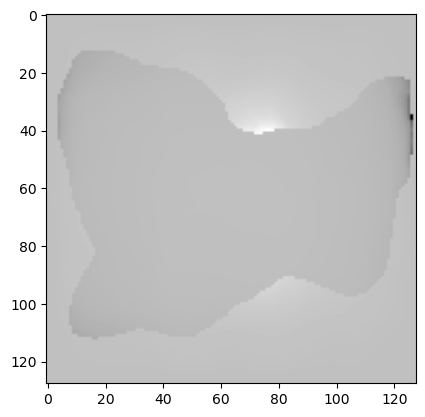

In [13]:
plt.imshow(x_test[27],cmap='gray')
model(x_test[236].reshape(1,128,128,1).to(device))

In [15]:
test_predicted_pair=list(zip(stats,np.array(np.exp(y_test))))
for elem in test_predicted_pair:
    print('The labeled permeability value is {} and predicted permeability value is {}'.format(elem[1],elem[0]))


The labeled permeability value is 1.2871306580564124e-06 and predicted permeability value is [1.2527207218226977e-06]
The labeled permeability value is 1.7827043166107615e-06 and predicted permeability value is [1.7823201687861001e-06]
The labeled permeability value is 1.6050192925831652e-06 and predicted permeability value is [1.6367113175874692e-06]
The labeled permeability value is 1.4814105497862329e-06 and predicted permeability value is [1.4712563825014513e-06]
The labeled permeability value is 1.5390766066047945e-06 and predicted permeability value is [1.5144094049901469e-06]
The labeled permeability value is 1.3343779983188142e-06 and predicted permeability value is [1.368585344607709e-06]
The labeled permeability value is 1.8983665768246283e-06 and predicted permeability value is [1.9508668174239574e-06]
The labeled permeability value is 1.774538532117731e-06 and predicted permeability value is [1.7966965515370248e-06]
The labeled permeability value is 1.5560357269350789e-06 a

In [19]:
max(stats)
index_max=np.argmax(stats)
print(index_max)

187


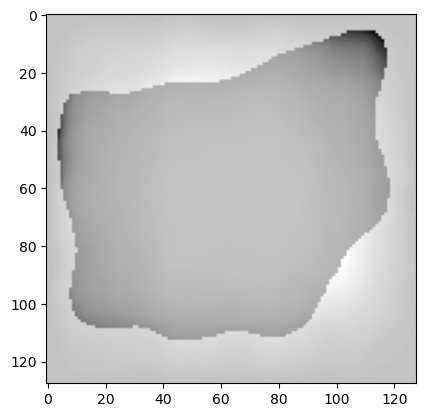

In [23]:
plt.imshow(x_test[index_max-1],cmap='gray')

Text(0.5, 1.0, 'scatter plot of permeability of test_images')

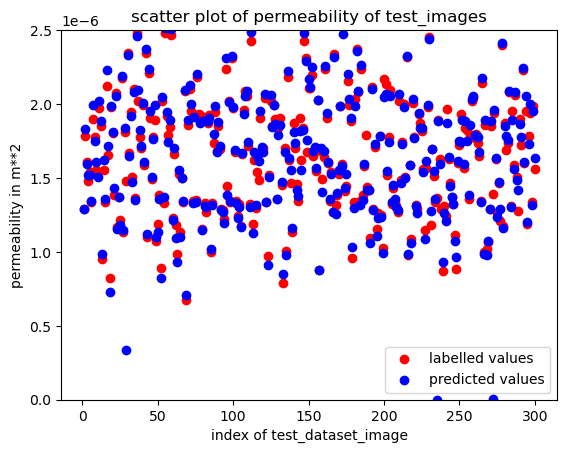

In [100]:
count=np.linspace(1,300,300)
plt.scatter(count,np.exp(y_test),color='r',label='labelled values')
plt.scatter(count,stats_array,color='b',label='predicted values')
plt.ylim(0,2.5e-6)
plt.legend()
plt.xlabel('index of test_dataset_image')
plt.ylabel('permeability in m**2')
plt.title('scatter plot of permeability of test_images')
#plt.scatter(stats,count,color='b')

Text(0.5, 1.0, 'scatter plot of permeability of test_images')

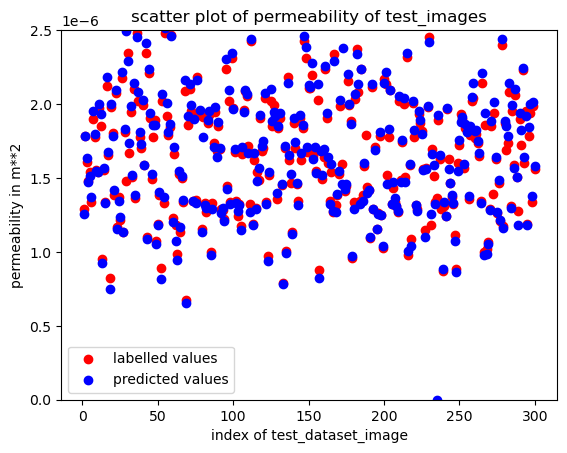

In [27]:
count=np.linspace(1,300,300)
stats_array=np.array(stats)
plt.scatter(count,np.exp(y_test),color='r',label='labelled values')
plt.scatter(count,stats_array,color='b',label='predicted values')
plt.ylim(0,2.5e-6)
plt.legend()
plt.xlabel('index of test_dataset_image')
plt.ylabel('permeability in m**2')
plt.title('scatter plot of permeability of test_images')
#plt.scatter(stats,count,color='b')

MemoryError: Unable to allocate 180. TiB for an array with shape (24764834957527,) and data type float64

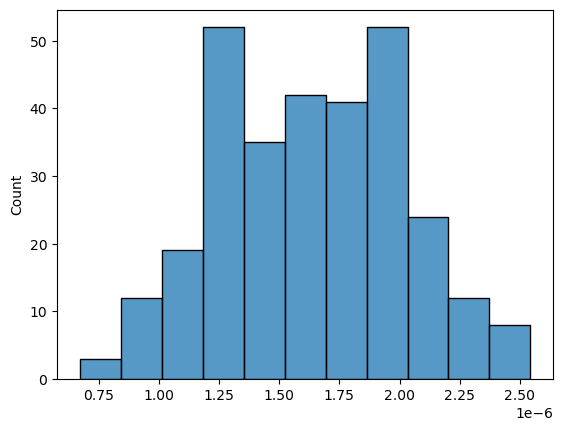

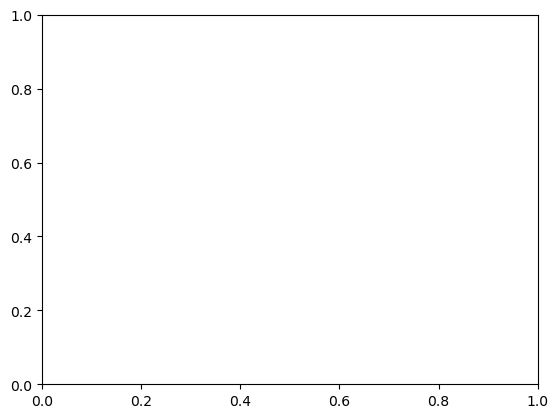

In [32]:
## checking for outliers
labels=np.exp(y_test)
figure=plt.figure()
sns.histplot(labels)
figure2=plt.figure()


MemoryError: Unable to allocate 180. TiB for an array with shape (24764834957527,) and data type float64

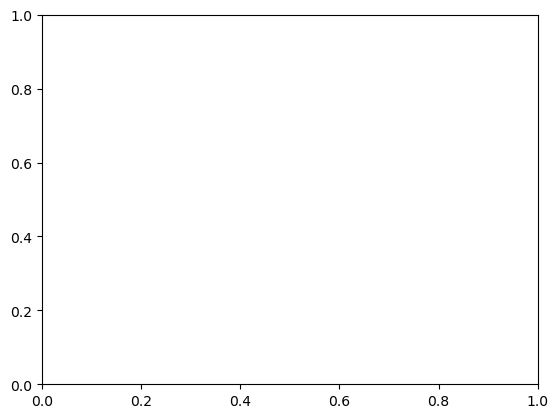

In [36]:
stats=

<Figure size 640x480 with 0 Axes>

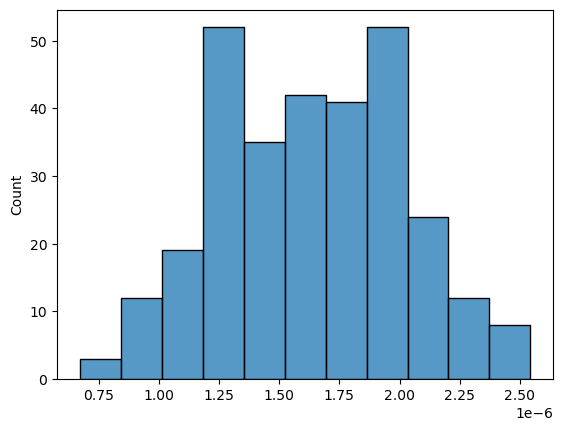

<Figure size 640x480 with 0 Axes>

In [117]:
sns.histplot(np.exp(y_test))
plt.figure()


MemoryError: Unable to allocate 180. TiB for an array with shape (24764834957527,) and data type float64

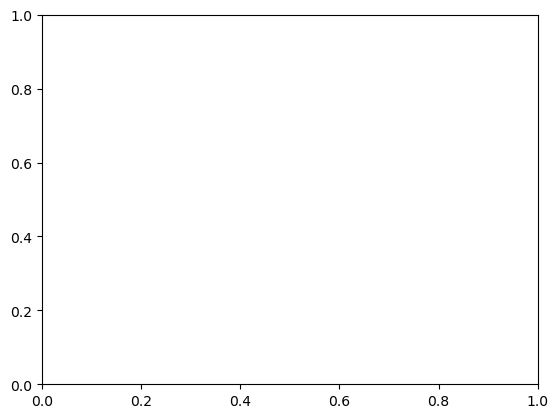

In [24]:
stats_array=np.array(stats)
#print(stats_array)


stats_array_sq=stats_array.reshape(300).tolist()
sns.histplot(stats_array_sq)

In [51]:
mean_square_error=0
for num in range(len(y_test)):
    mean_square_error+=(test_predicted_pair[num][1]-test_predicted_pair[num][0])**2
    print(mean_square_error)
print('The mean square error is {}'.format((mean_square_error)))

[2.43363366e-18]
[2.59081225e-15]
[2.8126062e-15]
[4.10184282e-15]
[4.38126941e-15]
[4.43863556e-15]
[1.32393679e-14]
[1.37592187e-14]
[1.64085094e-14]
[1.75010984e-14]
[1.9958257e-14]
[2.09840988e-14]
[2.22772e-14]
[2.72003772e-14]
[2.78041291e-14]
[3.96116814e-14]
[4.31578116e-14]
[5.2601536e-14]
[5.26937953e-14]
[5.27839052e-14]
[5.51129279e-14]
[5.5661198e-14]
[5.57307168e-14]
[5.57307277e-14]
[5.69110657e-14]
[5.69958144e-14]
[5.72108243e-14]
[5.80679922e-14]
[1.37092091e-12]
[1.37125489e-12]
[1.37163626e-12]
[1.37220061e-12]
[1.37306255e-12]
[1.37353343e-12]
[1.37374933e-12]
[1.37428619e-12]
[1.38054708e-12]
[1.3827934e-12]
[1.38291264e-12]
[1.38316979e-12]
[1.38369184e-12]
[1.38450807e-12]
[1.38509214e-12]
[1.38569776e-12]
[1.38831703e-12]
[1.38853362e-12]
[1.38879178e-12]
[1.39964485e-12]
[1.40047022e-12]
[1.40293389e-12]
[1.40360297e-12]
[1.40783578e-12]
[1.40838161e-12]
[1.40965232e-12]
[1.4110363e-12]
[1.41209854e-12]
[1.414372e-12]
[1.41680291e-12]
[1.41845621e-12]
[1.41856

In [55]:
max(test_predicted_pair)
max(y_train)

tensor(1.8439)

In [2]:
model

NameError: name 'model' is not defined

In [ ]:
## testing

prediction = torch.zeros(y_test.shape).cuda()
print(prediction.shape)

counter = 0
print(f' TEST SET SHAPE :: {y_test.shape}')

with torch.no_grad():
    for x , y in test_loader:
      x,y = x.cuda(), y.cuda()
      out = model(x).reshape(batch_size,strain_channels)  #out.shape[batchsize, 48,48, channels]
      out = y_normalizer.decode(out)
      print(out.shape)
      prediction[counter*batch_size: (counter*batch_size) + batch_size] = out
      counter+=1


In [ ]:
zpred = toNumpy(prediction)[0]
ytest = toNumpy(y_test)[0]
xcor,ycor = getgrid(x_train)   ## numpy arrays
xtest = toNumpy(test_geo)[0]

In [ ]:
index=66

geometry(xtest,index,pos='vert')
platter(ytest,zpred,index,name ='S')

In [ ]:
contour(ytest,zpred,xcor,ycor,index,cmap ='Reds')

In [ ]:
index=33

geometry(xtest,index,pos='vert')
platter(ytest,zpred,index,name ='S')

In [ ]:
contour(ytest,zpred,xcor,ycor,index,cmap ='Reds')

# ----------------------------------------------------------------------------------------

### STRESSES


In [ ]:
## hyp par settings

batch_size = 20
learning_rate = 0.01
step_size = 100
epochs = 300
gamma = 0.5
modes =12
width = 32

In [ ]:
x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

dim = 128 # image resolution

x_train = x_train.reshape(ntrain,dim,dim,1)
x_test = x_test.reshape(ntest,dim,dim,1)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [16]:
strain_channels = 1
model = FNO2d(modes, modes, width, strain_channels).cuda()
print(f'MODEL PARAMETERS. :== {count_params(model)}')

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

MODEL PARAMETERS. :== 210903625


In [17]:

myloss = L2Loss(size_average=False)
y_normalizer.cuda()

## ep wise error
trainerror=[] 
testerror=[]

##Train Test Loop
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,strain_channels)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).reshape(batch_size, dim, dim,strain_channels)
            out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

RuntimeError: shape '[20, 128, 128, 1]' is invalid for input of size 20

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [ ]:
## testing

prediction = torch.zeros(ytest.shape).cuda()

counter = 0
print(f' TEST SET SHAPE :: {ytest.shape}')

with torch.no_grad():
    for x , y in test_loader:
      x,y = x.cuda(), y.cuda()
      out = model(x).reshape(batch_size,48,48,strain_channels)  #out.shape[batchsize, 48,48, channels]
      out = y_normalizer.decode(out)
      prediction[counter*batch_size: (counter*batch_size) + batch_size] = out
      counter+=1

In [ ]:
zpred = toNumpy(prediction)[0]
ytest = toNumpy(y_test)[0]
xcor,ycor = getgrid(x_train)   ## numpy arrays
xtest = toNumpy(test_geo)[0]

In [ ]:
index=55
geometry(xtest,index,pos='vert')
platter(ytest,zpred,index,name ='S')

In [ ]:
index =22
contour(ytest,zpred,xcor,ycor,index,cmap ='plasma_r')